# Hyperskill python dataset analysis (long submission series)

## Settings

In [1]:
import pandas as pd
import numpy as np

from typing import List, Dict
import string
import sys
import os

import importlib

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})

In [2]:
module_path = os.path.abspath(os.path.join('../../../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import analysis
importlib.reload(analysis)

from analysis.src.python.data_analysis.analysis.attrs import draw_base_attrs

from analysis.src.python.data_analysis.analysis.statistics import \
    get_submissions_percent_by_issues, get_client_stats, \
    get_submissions_series_dynamic_by_feature, get_submissions_series_issues_dynamic, \
    get_top_issues, get_submissions_percent_by_feature, \
    get_submissions_series_client_dynamic

from analysis.src.python.data_analysis.analysis.plots import \
    draw_compare, draw_heatmap_compare, \
    draw_hist_plots, draw_count_plots, \
    draw_stat_plot, draw_client_dynamic_graph

from analysis.src.python.data_analysis.stat_test.iticse_2022.rq_stat_tests import run_stat_tests

/Users/tiginamaria1999/PycharmProjects/hyperstyle-analyze/venv/src/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
def merge_dfs(df_left: pd.DataFrame, df_right: pd.DataFrame, left_on: str, right_on: str) -> pd.DataFrame:
    df_merged = pd.merge(df_left, df_right, left_on=left_on, right_on=right_on, suffixes=('', '_extra'))
    df_merged.drop(df_merged.filter(regex='_extra$').columns.tolist(), axis=1, inplace=True)
    return df_merged

In [4]:
def get_tag(count, scope_borders, labels) -> str:
    if count <= scope_borders[0]:
        return labels[0]
    if count >= scope_borders[1]:
        return labels[2]
    return labels[1]

### Set path to following csv files (or use preset default)

In [5]:
data_directory_path = '/Users/tiginamaria1999/PycharmProjects/hyperstyle-analyze/analysis/src/resources/data/python_new'
steps_file_path = os.path.join(data_directory_path, 'steps_prep.csv')
topics_file_path = os.path.join(data_directory_path, 'topics_prep.csv')

submissions_file_path = os.path.join(data_directory_path, 'solutions_python3_prep.csv')
submissions_stats_file_path = os.path.join(data_directory_path, 'solutions_python3_prep_stats.csv')

hyperstyle_issues_file_path = os.path.join(data_directory_path, 'solutions_python3_prep_hyperstyle_filtered_issues.csv')
hyperstyle_issues_stats_file_path = os.path.join(data_directory_path, 'solutions_python3_prep_hyperstyle_filtered_issues_stats.csv')
hyperstyle_issues_classes_file_path = os.path.join(data_directory_path, 'hyperstyle_issues.csv')


### Color pallents of main attributes

difficulty
easy -> medium -> hard


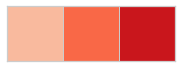

complexity
shallow -> middle -> deep


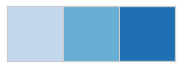

scope
small -> medium -> wide


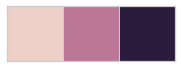

level
low -> average -> high


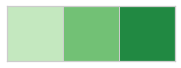

client
idea -> web


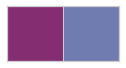

In [6]:
draw_base_attrs()

## Long submission series analysis

In [7]:
BASE_PATH = os.path.join('python', 'long_series')
ATTEMPTS_STATS_PATH = os.path.join(BASE_PATH, 'attempts_stats')

os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(ATTEMPTS_STATS_PATH, exist_ok=True)

In [8]:
df_hyperstyle_issues_stats = pd.read_csv(hyperstyle_issues_stats_file_path)
df_hyperstyle_issues_stats.shape

(1404532, 366)

In [9]:
df_submissions = pd.read_csv(submissions_file_path)
df_submissions.shape

(1404532, 12)

In [10]:
df_submissions['user_id'].value_counts()

2050     35423
2081      3507
55101      571
27084      549
49258      454
         ...  
79707        1
81754        1
75609        1
72819        1
4840         1
Name: user_id, Length: 46867, dtype: int64

In [11]:
df_submissions[df_submissions['user_id'] == 2050]['step_id'].value_counts()

6462    3347
6469    1944
6549    1739
7927    1698
6308    1352
        ... 
6559       1
6719       1
6526       1
6404       1
6791       1
Name: step_id, Length: 194, dtype: int64

In [12]:
df_submissions[df_submissions['user_id'] == 2081]['step_id'].value_counts()

6468     737
9148     561
9149     407
6881     405
8440     348
8076     325
8921     221
8923     140
10214    106
10216     85
10213     56
8131      42
10215     29
14256     18
14590     12
14615      8
8920       3
8132       2
5871       1
6465       1
Name: step_id, dtype: int64

In [13]:
df_submissions = df_submissions[~df_submissions['user_id'].isin([2050, 2081])]
df_submissions.shape

(1365602, 12)

In [15]:
df_total_attempts_stats = df_submissions[df_submissions['attempt'] == 1] \
    .groupby('step_id') \
    .agg({'total_attempts': ['median', 'mean']})

df_total_attempts_stats.sort_values(by=('total_attempts', 'median'), ascending=False)

total_attempts          
                median      mean
step_id                         
8441               2.0  2.076690
13808              2.0  2.259740
6942               2.0  1.912734
15150              2.0  1.769231
15077              2.0  1.937500
...                ...       ...
6962               1.0  1.052957
6936               1.0  1.264577
6935               1.0  1.274121
6900               1.0  1.094089
15188              1.0  1.000000

[364 rows x 2 columns]

In [16]:
df_submissions_long = df_submissions[df_submissions['total_attempts'] > 5]
df_submissions_long.shape

(20361, 12)

In [17]:
series_attempts_count = df_submissions_long[df_submissions_long['attempt'] == 1]['total_attempts'].value_counts()
series_attempts_count = series_attempts_count.reset_index()
series_attempts_count.columns = ['unique_values', 'counts']
series_attempts_count.to_csv(os.path.join(ATTEMPTS_STATS_PATH, 'series_attemps_count.csv'), index=False)
series_attempts_count

,unique_values,counts
0,6,1342
1,7,638
2,8,349
3,9,180
4,10,107
5,11,54
6,12,32
7,13,20
8,14,17
9,15,11


In [18]:
df_long_examples = df_submissions_long[df_submissions_long['total_attempts'] >= 20] \
                            .groupby(['step_id', 'user_id']) \
                            .agg({'total_attempts': 'first'}) \
                            .sort_values(by='total_attempts') \
                            .reset_index()

df_long_examples

,step_id,user_id,total_attempts
0,6809,59606,20
1,6810,53411,20
2,7076,54187,22
3,8438,44187,22
4,6380,54266,23
5,5938,46135,25
6,6609,55101,25
7,9476,58093,25
8,6379,55670,27
9,6519,64458,27


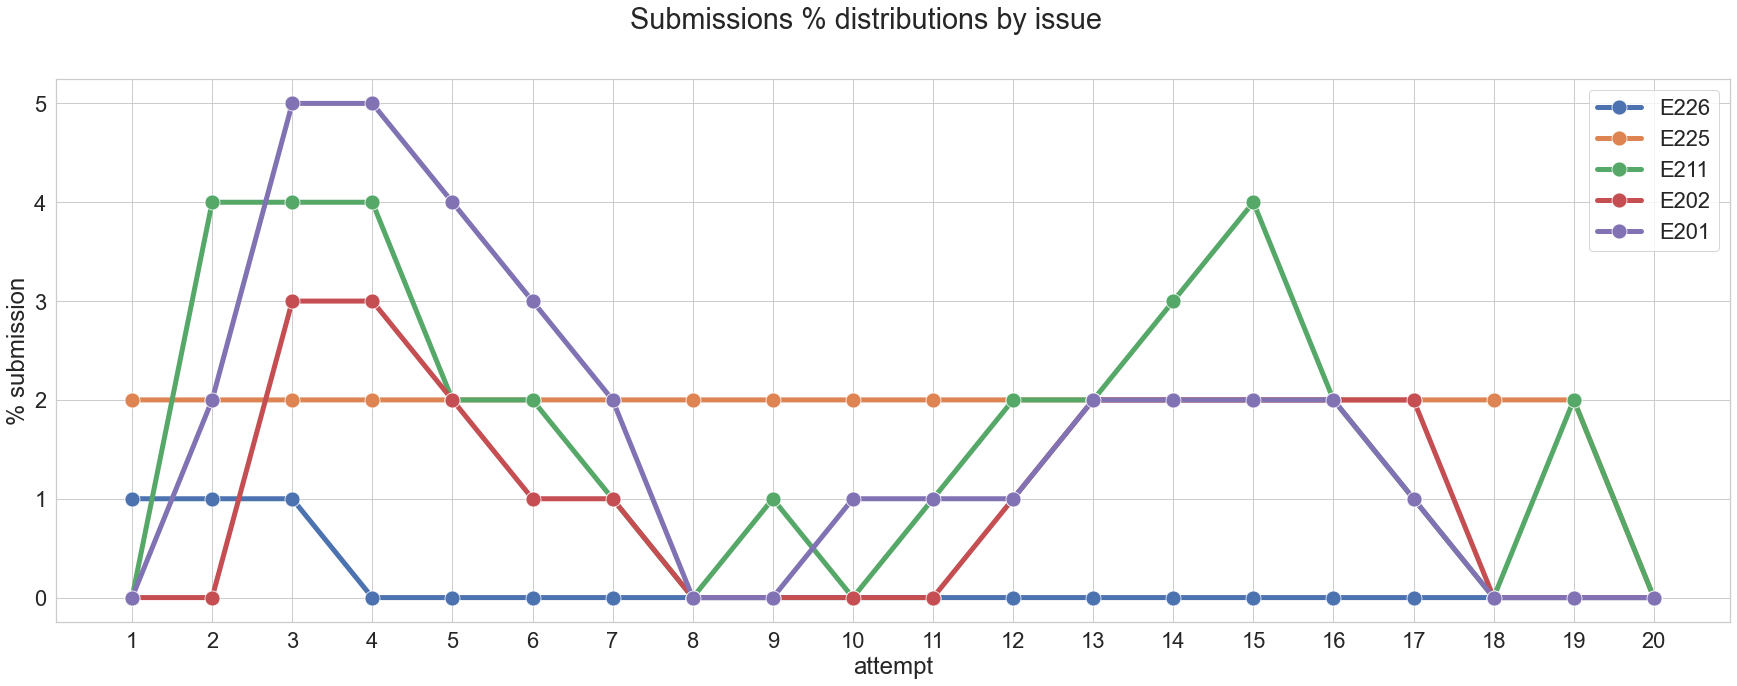

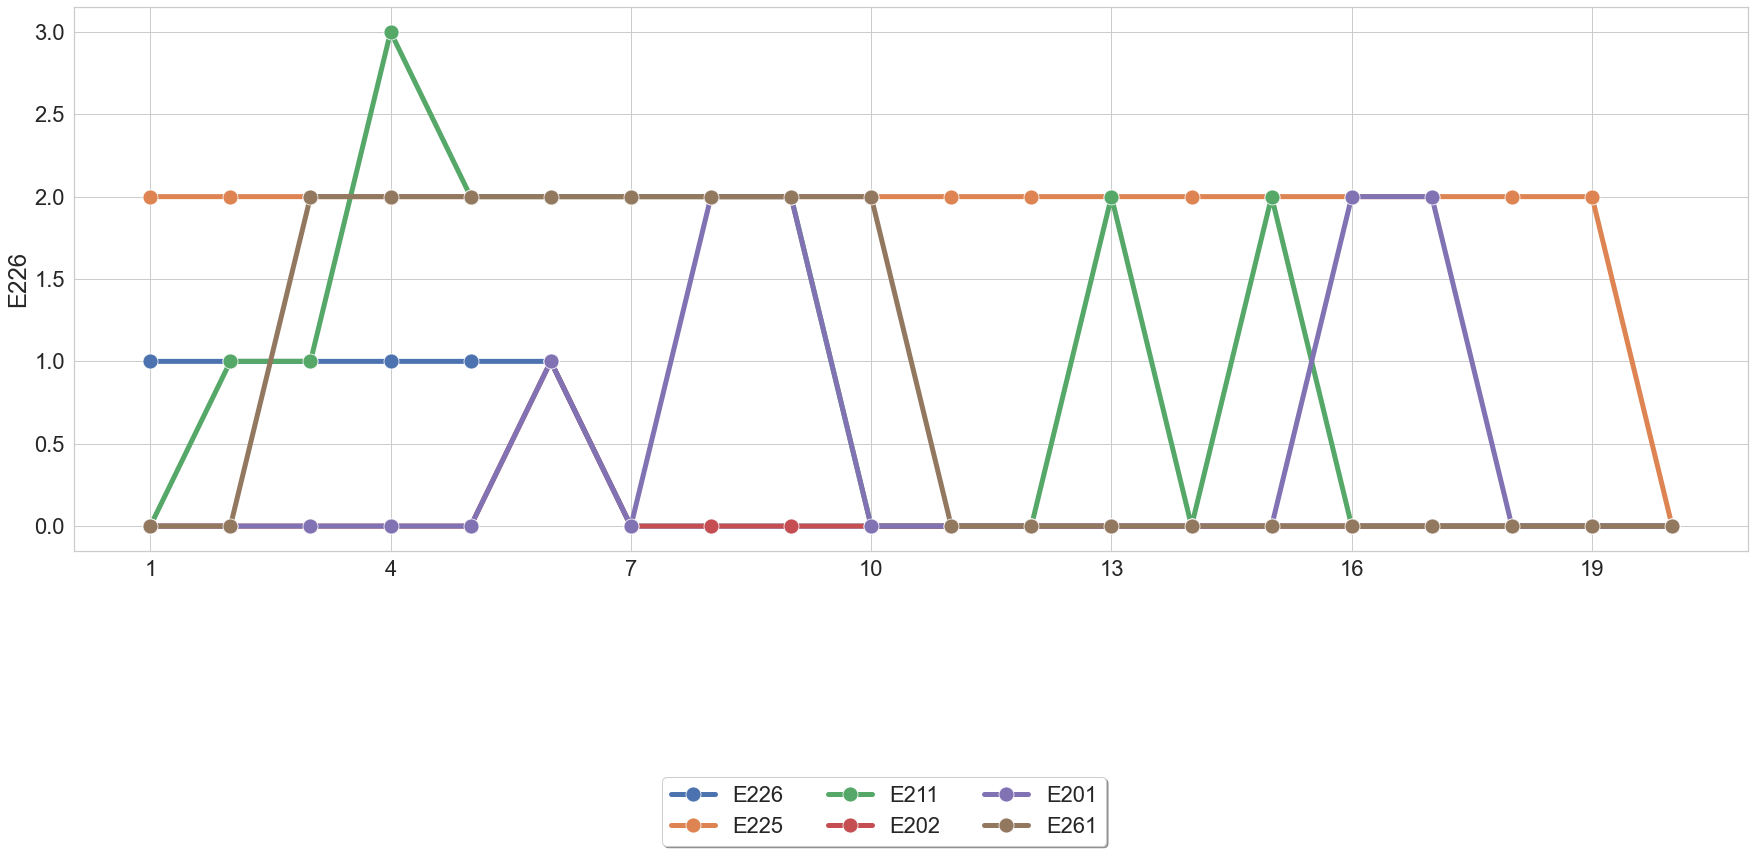

<Figure size 432x288 with 0 Axes>

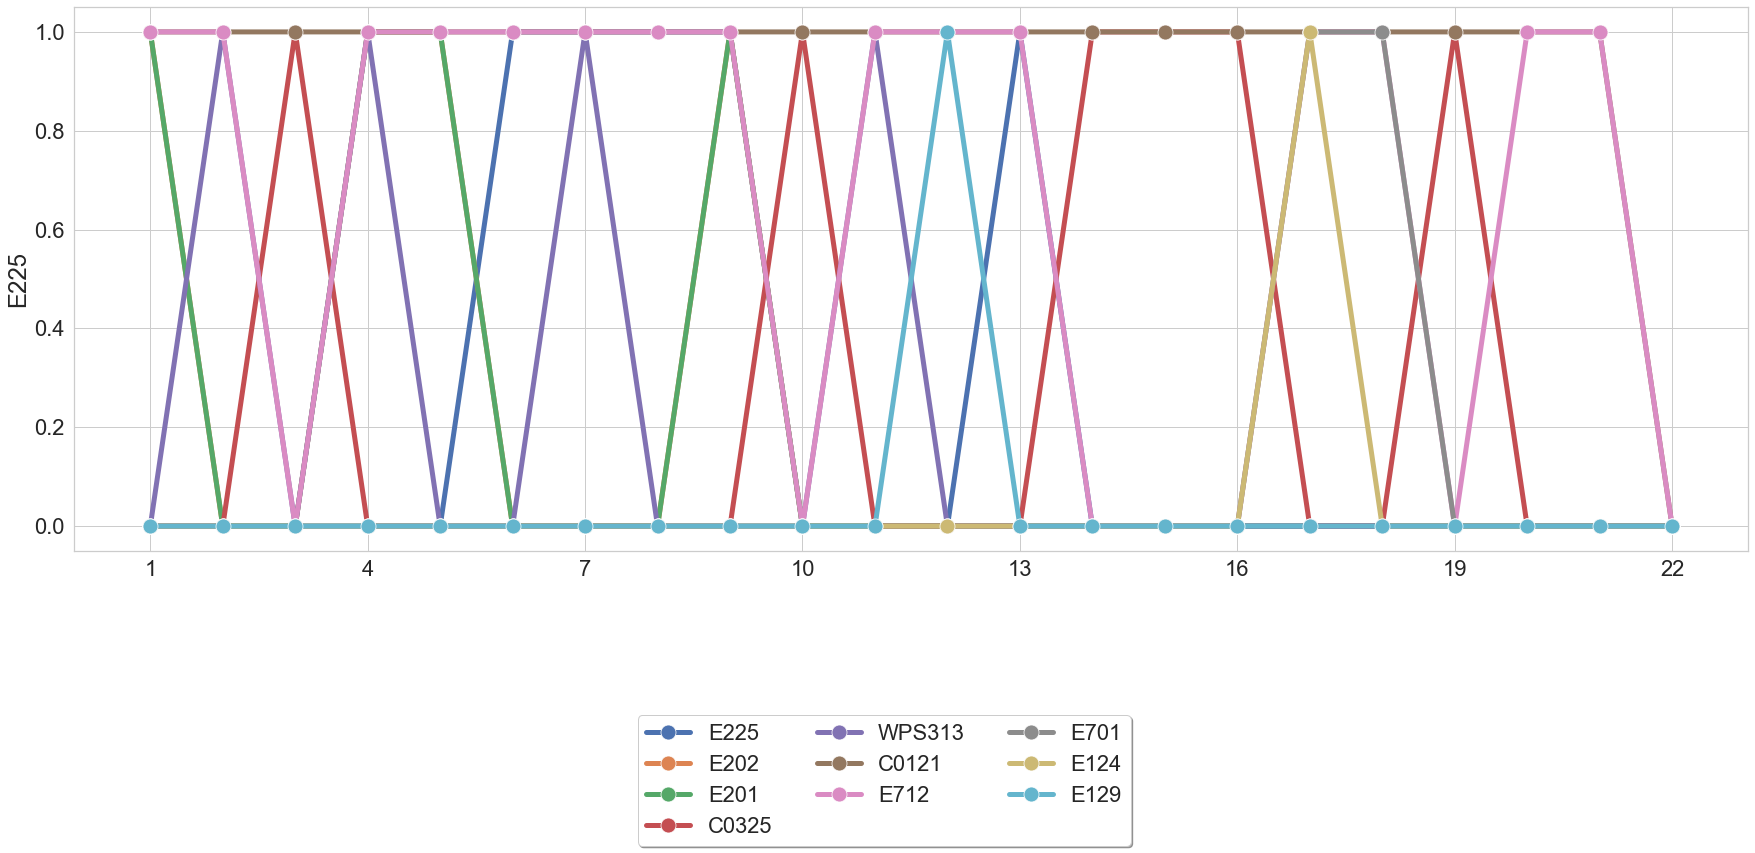

<Figure size 432x288 with 0 Axes>

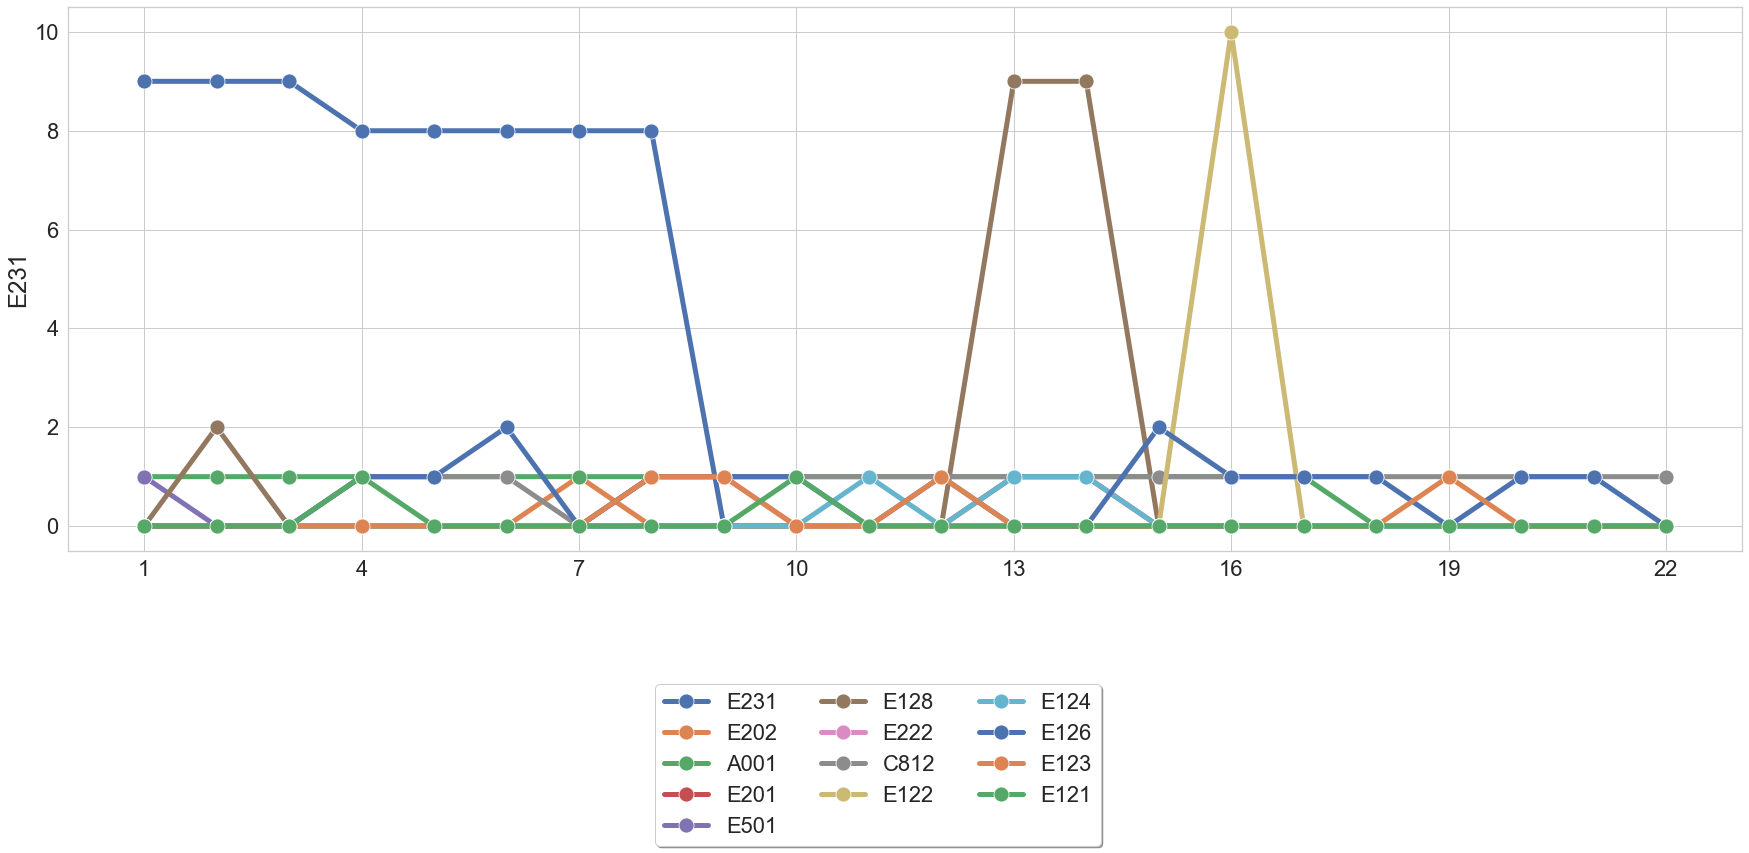

<Figure size 432x288 with 0 Axes>

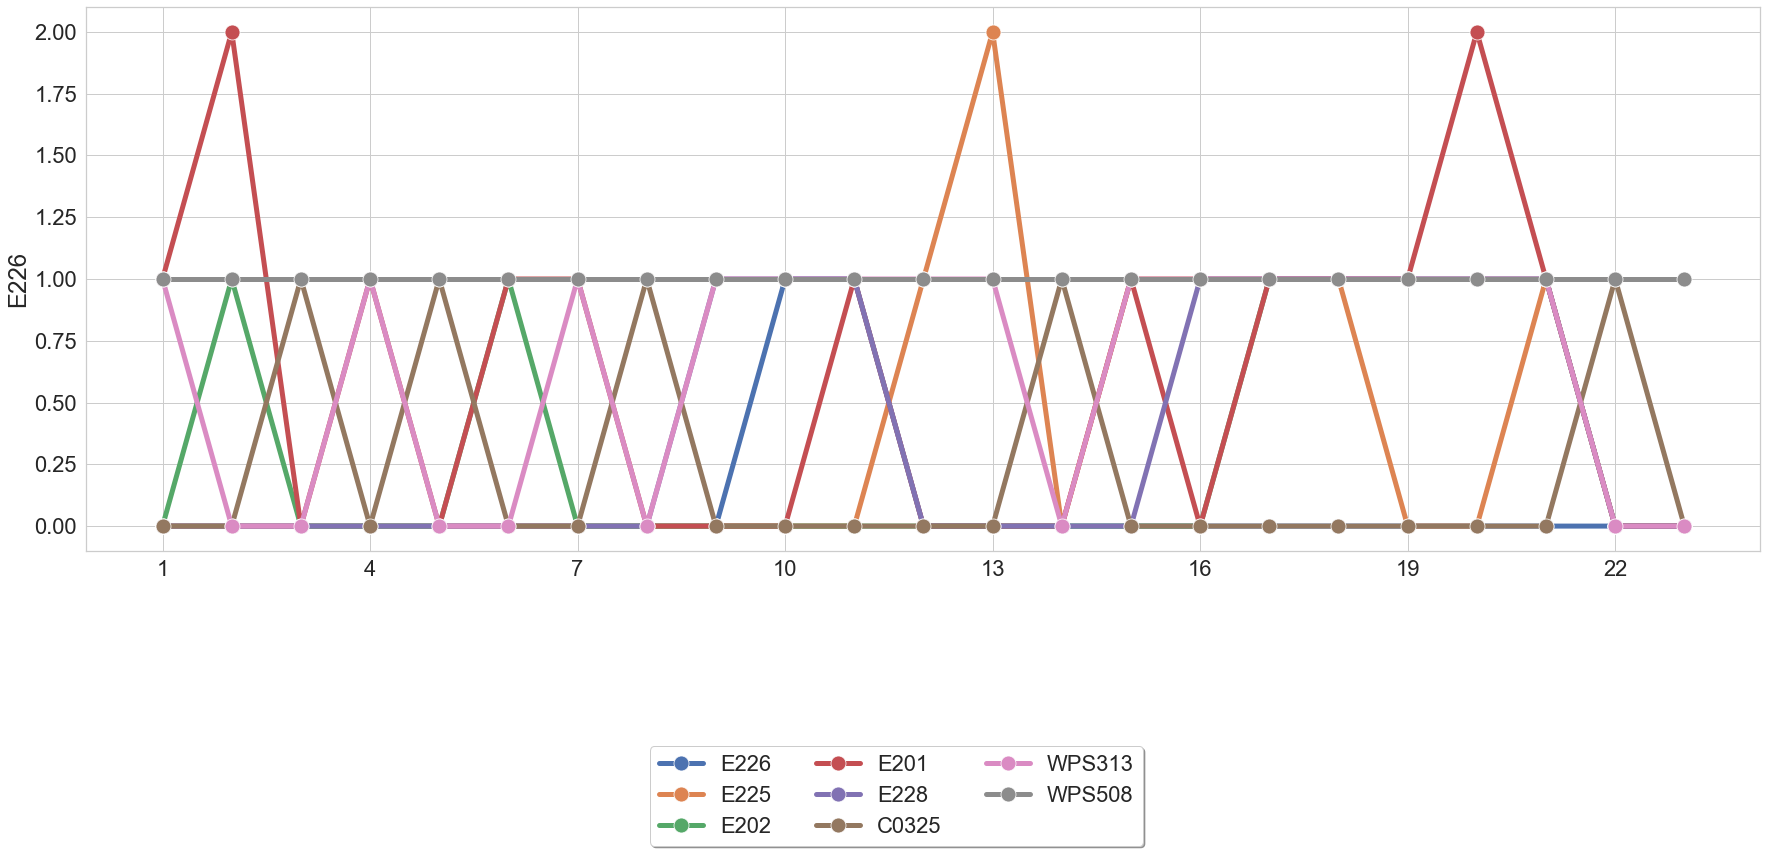

<Figure size 432x288 with 0 Axes>

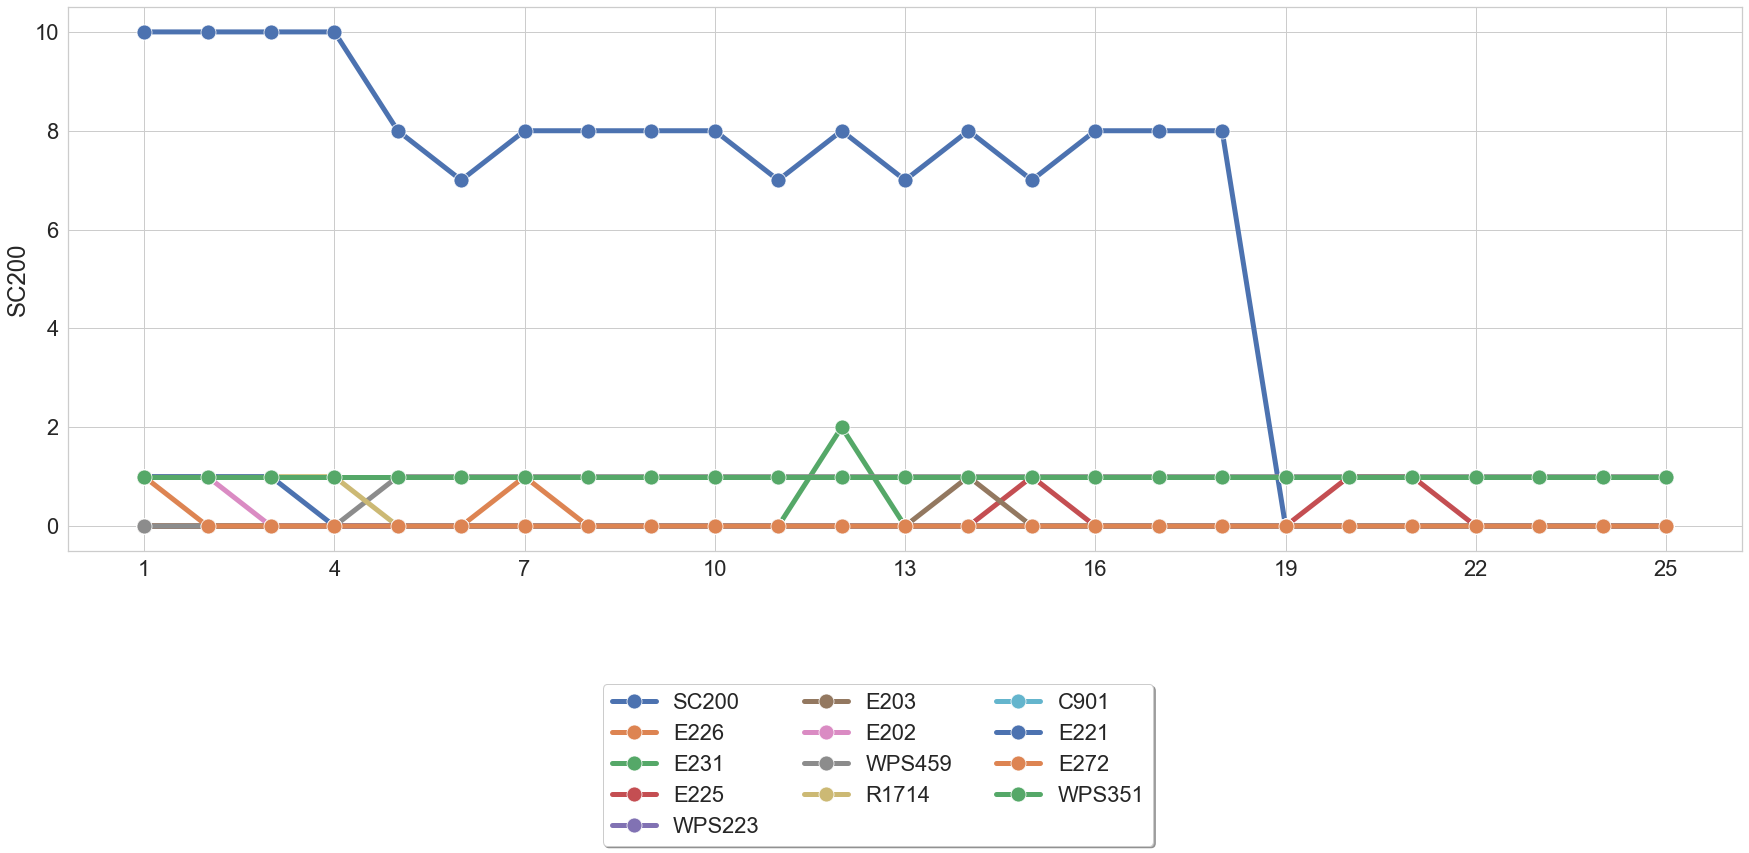

<Figure size 432x288 with 0 Axes>

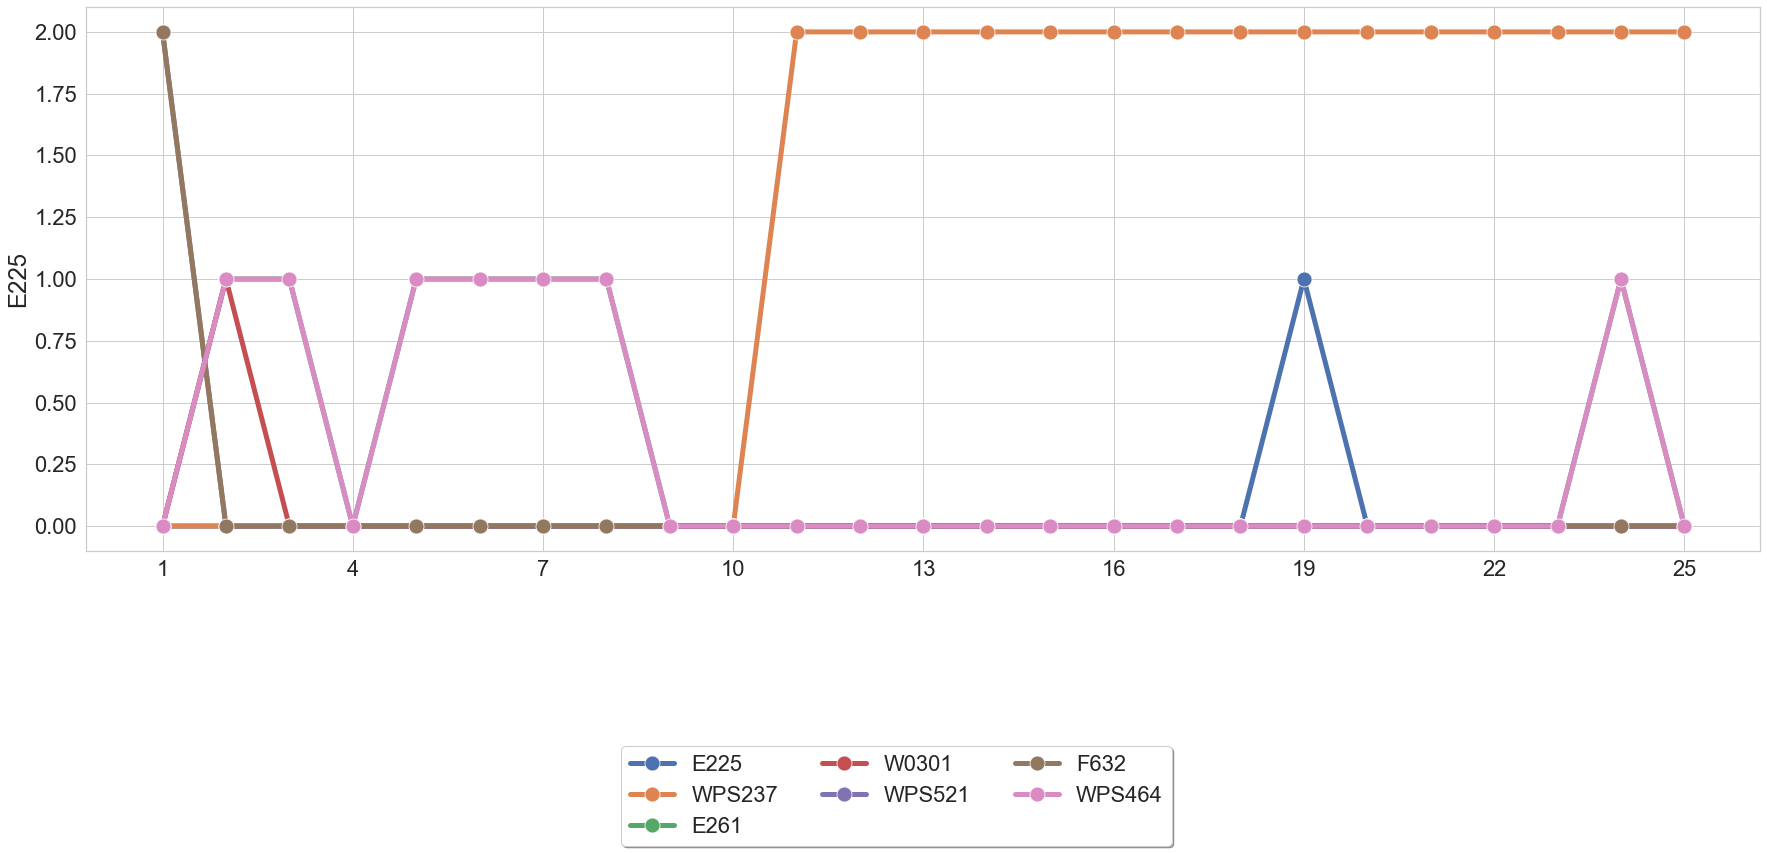

<Figure size 432x288 with 0 Axes>

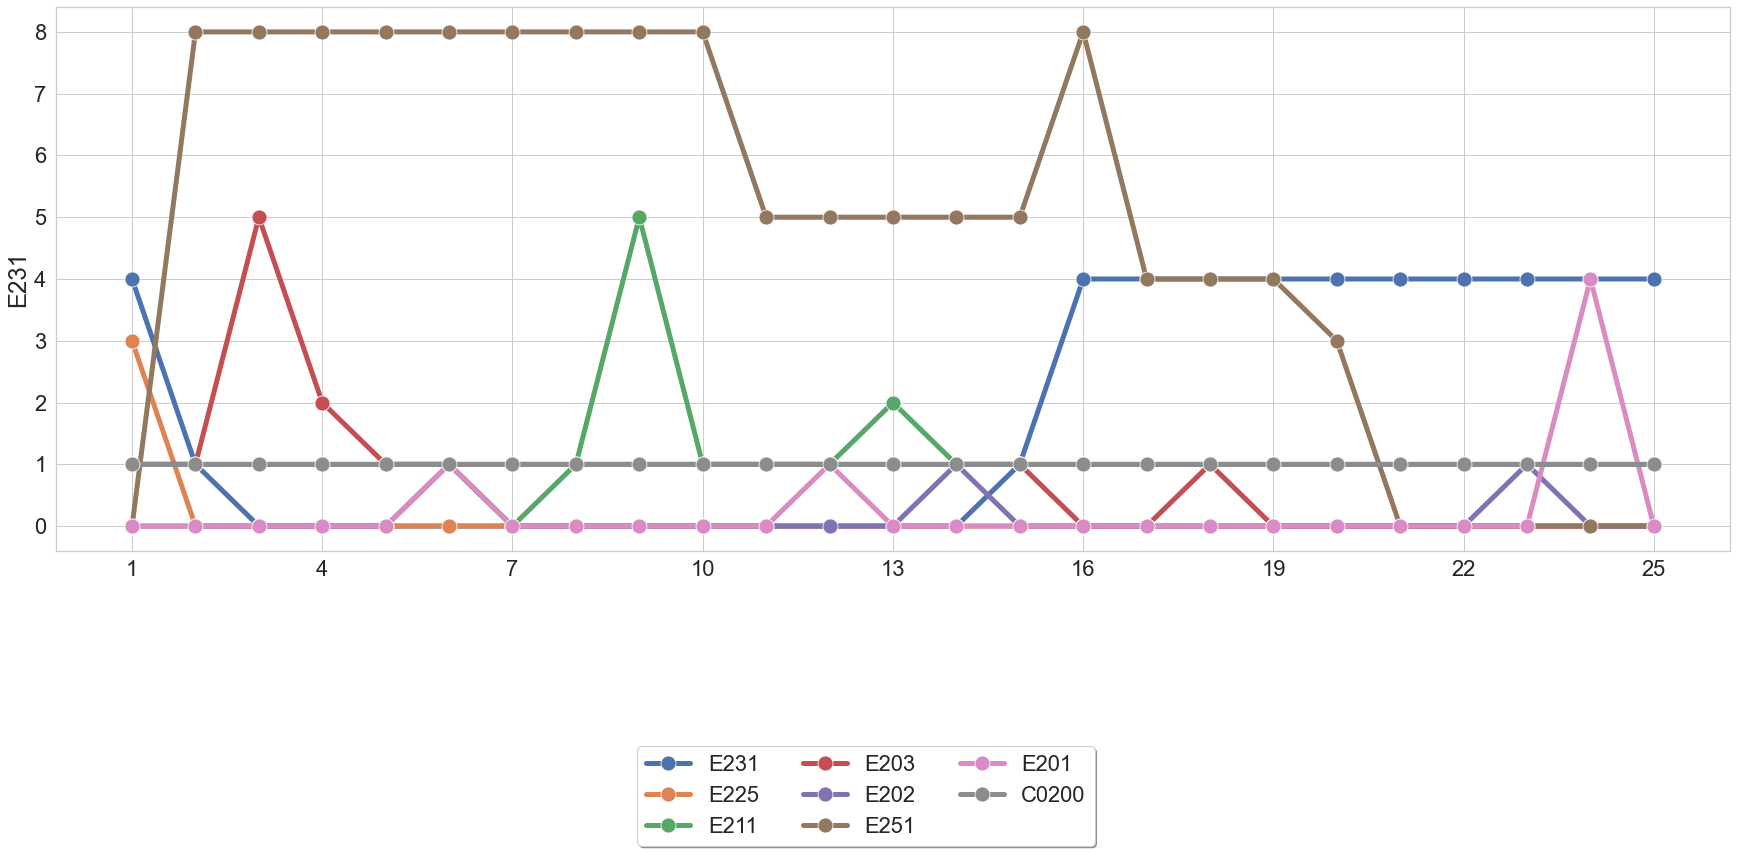

<Figure size 432x288 with 0 Axes>

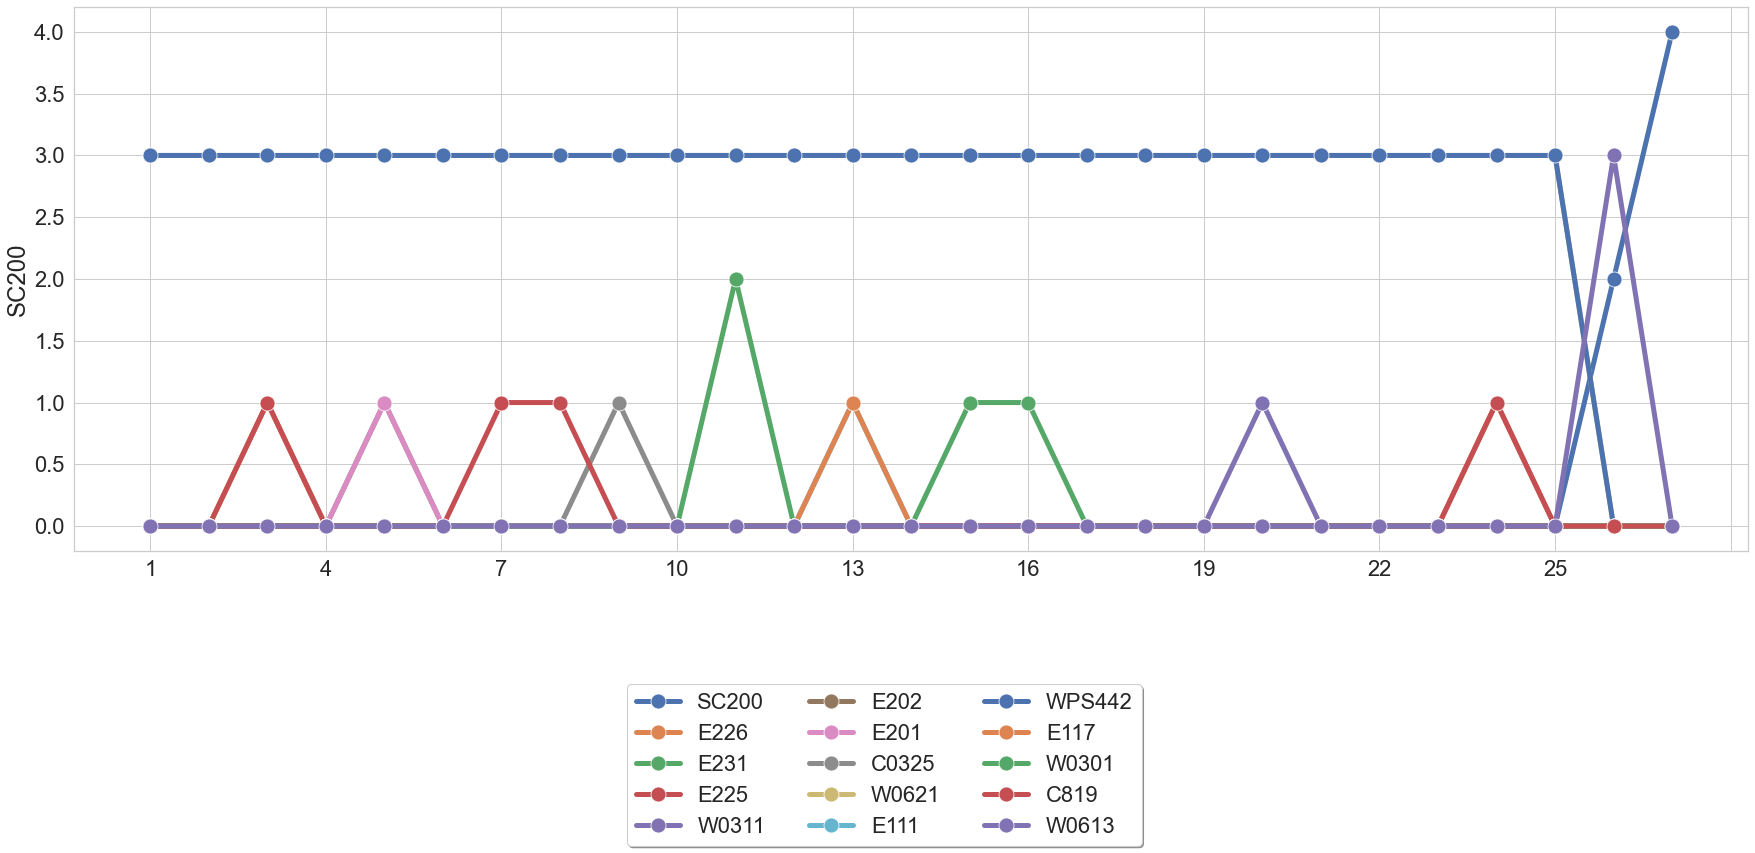

<Figure size 432x288 with 0 Axes>

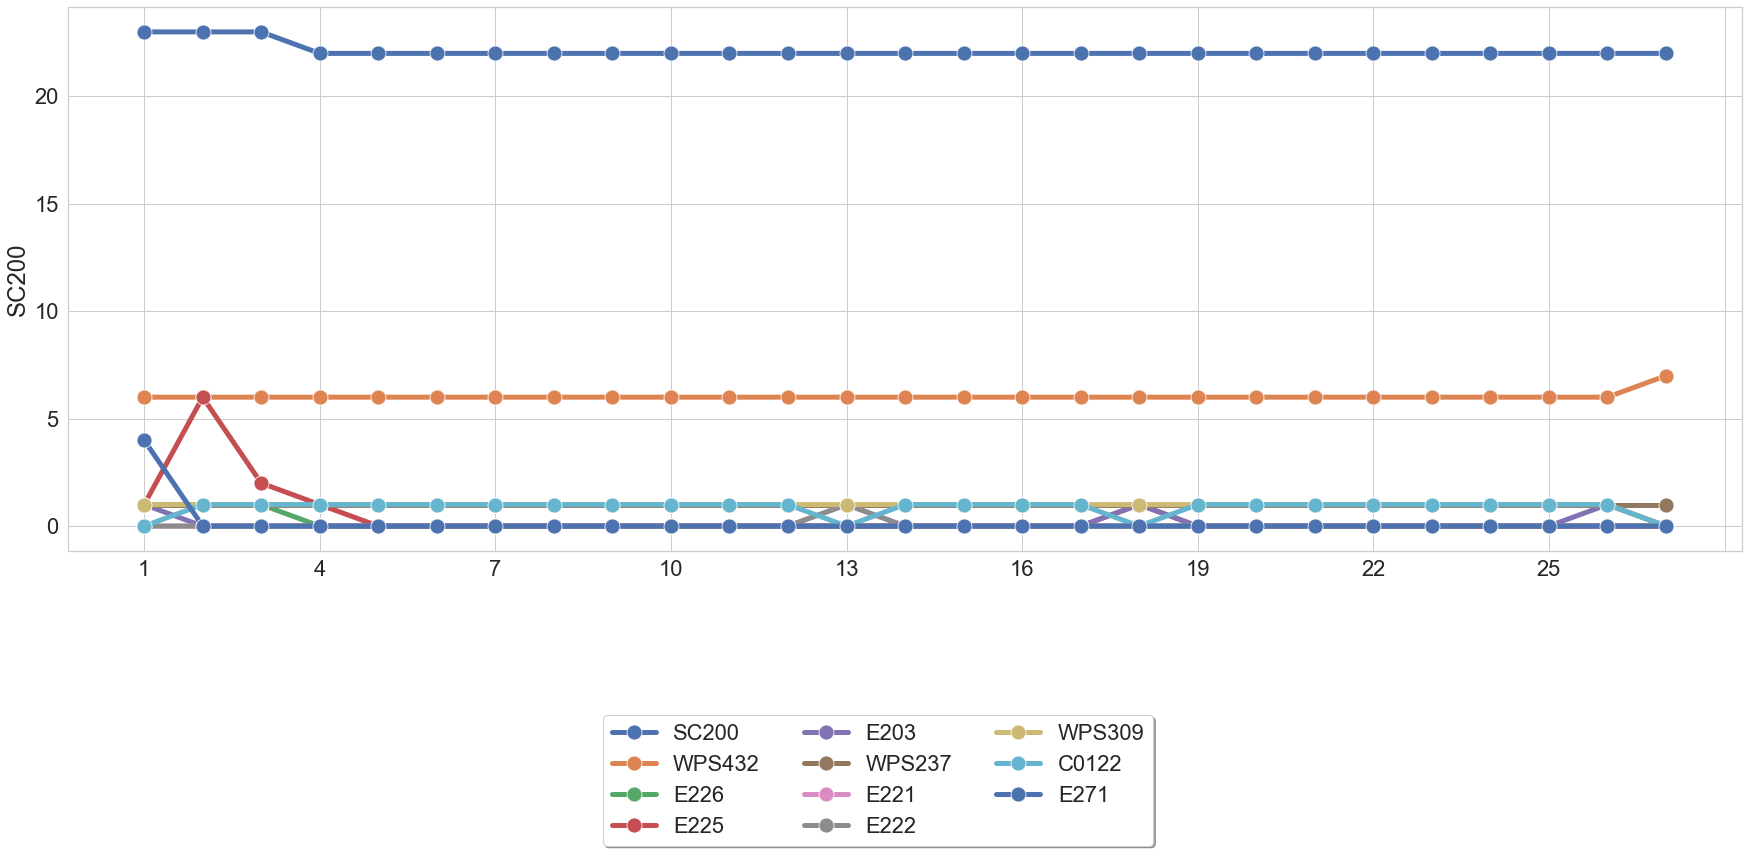

<Figure size 432x288 with 0 Axes>

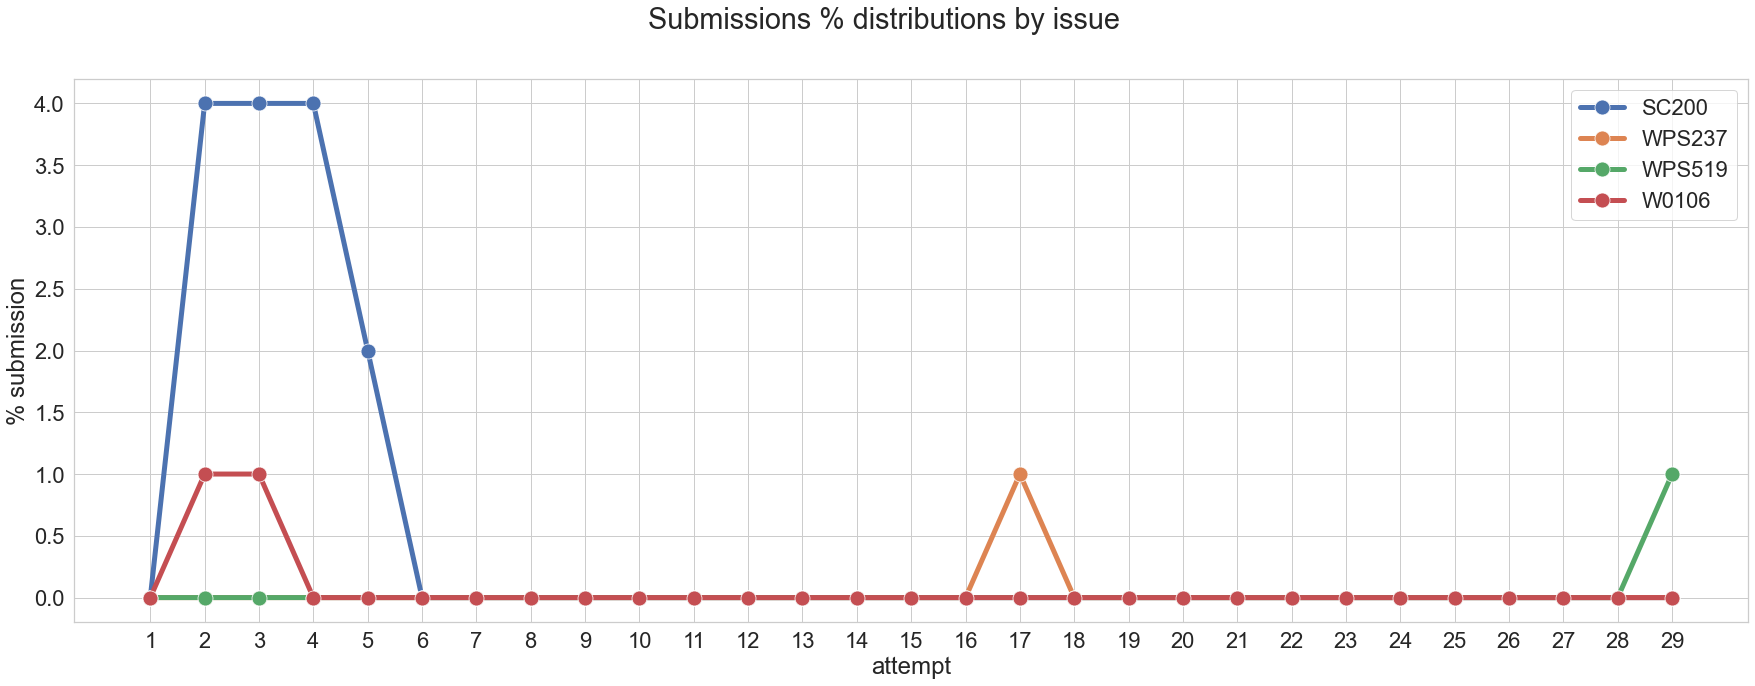

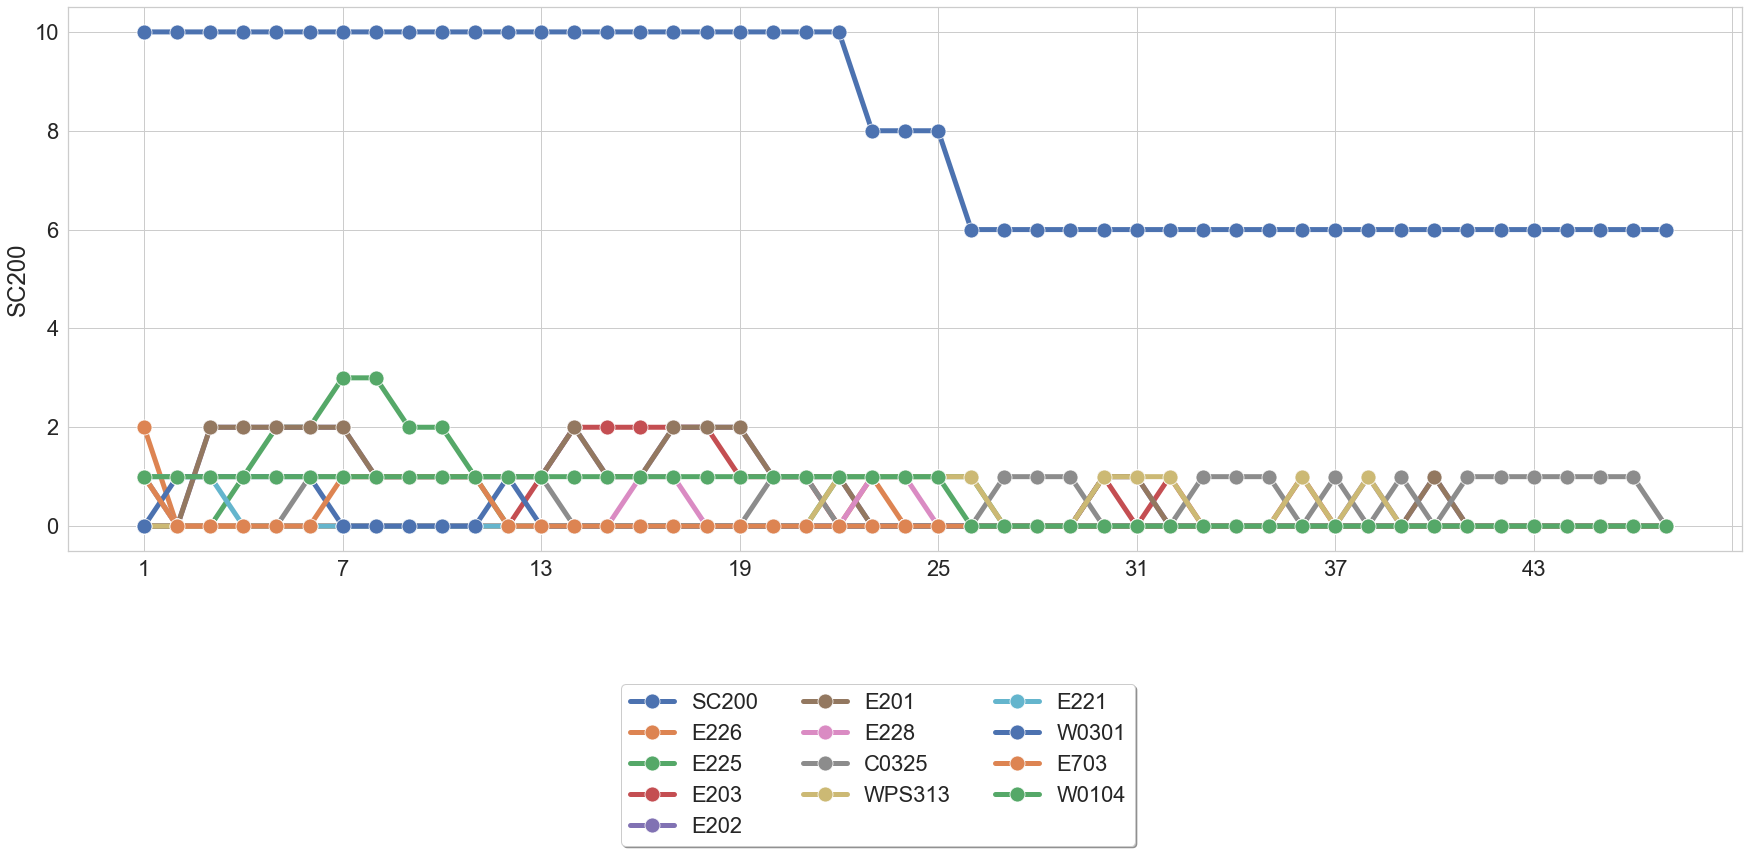

<Figure size 432x288 with 0 Axes>

In [20]:
for _, df_long_example in df_long_examples.iterrows():
    user_id = df_long_example['user_id']
    step_id = df_long_example['step_id']
    total_attempts = df_long_example['total_attempts']
    
    df_long_series = df_submissions_long[(df_submissions_long['step_id'] == step_id) & 
                                         (df_submissions_long['user_id'] == user_id)]

    df_long_issues = df_hyperstyle_issues_stats[df_hyperstyle_issues_stats['id'].isin(df_long_series['id'])]
    
    issues = [i for i in df_long_issues.columns if (i != 'id') and (df_long_issues[i].sum() > 0)]
    df_long_issues = df_long_issues[issues + ['id']]
    
    df_long_stats = pd.merge(df_long_series, df_long_issues, left_on='id', right_on='id')
    
    df_long_stats.to_csv(os.path.join(ATTEMPTS_STATS_PATH, f'submissions_{total_attempts}_{step_id}_{user_id}.csv'), 
                index=False)
    
    draw_compare(df_long_stats, 'attempt', ('issue', issues))